## Imports

In [4]:
import os
import json
import argparse
from pathlib import Path
import json
from tqdm import tqdm
from urllib.request import urlopen
import random

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import models, transforms, datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Config variables

In [9]:
MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

## Task 1: Basics

### DataLoader for ImageFolder at `dataset_path`

In [ ]:
def get_dataloader(dataset_path, batch_size=BATCH_SIZE, shuffle=False):
    # Apply the transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
    # Initialize the dataset
    dataset = datasets.ImageFolder(dataset_path, transform=transform)

    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle), dataset

### Load JSON file for labels

In [ ]:
def load_label_map(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

### Preprocess labels

####  Build synset named folders to global index (0-999) mapping

In [ ]:
# Fetch the standard ImageNet class index
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

# Download the class index
with urlopen(url) as resp:
    imagenet_idx = json.load(resp)

# Build synset -> global index (0–999)
synset_to_global = {v[0]: int(k) for k, v in imagenet_idx.items()}

#### Load labels list

In [ ]:
subset_labels = load_label_map("/content/TestDataSet/labels_list.json")
subset_labels[:10]

['401: accordion',
 '402: acoustic guitar',
 '403: aircraft carrier',
 '404: airliner',
 '405: airship',
 '406: altar',
 '407: ambulance',
 '408: amphibian',
 '409: analog clock',
 '410: apiary']

#### Extract the global ImageNet indices for our subset

In [ ]:
subset_global_idxs = [int(item.split(":")[0]) for item in subset_labels]

#### Make global label to class name index map

In [ ]:
label_idx_map = {int(item.split(":")[0]): item.split(":")[1].strip() for item in subset_labels}

### Construct dataloader

In [ ]:
dataloader, dataset = get_dataloader("/content/TestDataSet/")

# local subset idx for each synset folder
synsets = dataset.classes   # e.g. ["n02672831", "n02676566", …]
synset_to_local = dataset.class_to_idx

# link local → global via your subset list:
# subset_global_idxs[i] is the global label for local index i
local_to_global = {i: subset_global_idxs[i] for i in range(len(synsets))}

### Initialize the ResNet34 Model

In [11]:
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 76.3MB/s]


### Evaluate model on original test set

In [ ]:
model.eval()

topk = (1, 5)
correct = {k: 0 for k in topk}
total = 0

for imgs, targets in tqdm(dataloader):
    imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
    global_targs = torch.tensor(
        [local_to_global[int(l)] for l in targets],
        device=DEVICE,
    )
    logits = model(imgs)
    for k in topk:
        _, pred = logits.topk(k, dim=1, largest=True, sorted=True)
        correct[k] += (pred == global_targs.view(-1,1)).any(dim=1).sum().item()
    total += targets.size(0)
baseline = {f"top{k}": correct[k]/total for k in topk}


print("\nTask 1: ResNet-34 baseline:")
print("Top-1 accuracy: ", baseline['top1'] * 100)
print("Top-5 accuracy: ", baseline['top5'] * 100)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 119MB/s]
100%|██████████| 16/16 [00:02<00:00,  5.82it/s]


Task 1: ResNet-34 baseline:
Top-1 accuracy:  76.0
Top-5 accuracy:  94.19999999999999


## Task 2: Pixel-wise attacks

### Fast Gradient Sign Method (FGSM) attack method

In [ ]:
def fgsm_attack(x, y, model, epsilon=0.02):
    x_adv = x.clone().to(DEVICE)
    x_adv.requires_grad = True
    logits = model(x_adv)
    loss = F.cross_entropy(logits, y)
    loss.backward()

    # single‐step sign‐gradient
    x_adv = x_adv + epsilon * x_adv.grad.sign()

    # clamp each channel back to valid [0,1] in normalized space
    for c in range(3):
        x_adv[:,c] = torch.clamp(
            x_adv[:,c],
            (0 - MEAN[c]) / STD[c],
            (1 - MEAN[c]) / STD[c]
        )
    return x_adv.detach()

### Common evaluate method to get top-1 and top-5 accuracies

In [22]:
# Compute top-1 and top-5 accuracy on loader.
@torch.no_grad()
def evaluate(model, loader, topk=(1,5)):
    model.eval()
    correct = {k: 0 for k in topk}
    total = 0
    for imgs, targets in tqdm(loader):
        imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
        logits = model(imgs)
        for k in topk:
            _, pred = logits.topk(k, dim=1, largest=True, sorted=True)
            correct[k] += (pred == targets.view(-1,1)).any(dim=1).sum().item()
        total += targets.size(0)
    return {f"top{k}": correct[k]/total for k in topk}

### Build the adversarial test set using FGSM

In [7]:
# Attack budget
epsilon = 0.02
adv_imgs, adv_lbls, orig_imgs, orig_lbls = [], [], []

for x, y in dataloader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    # Map local indices (eg. 0, 1, 2...) to global ImageNet indices (eg, 401, 402, ...)
    y = torch.tensor([local_to_global[l.item()] for l in y]).to(DEVICE)

    # Attack the dataset
    adv = fgsm_attack(x, y, model, epsilon)

    adv_imgs.append(adv.cpu())
    adv_lbls.append(y.cpu())
    orig_imgs.append(x.cpu())
    orig_lbls.append(y.cpu())

adv_imgs = torch.cat(adv_imgs)
adv_lbls = torch.cat(adv_lbls)
orig_imgs = torch.cat(orig_imgs)
orig_lbls = torch.cat(orig_lbls)

print(f"Total Adversarial samples: {len(adv_imgs)}")

Total Adversarial samples: 500


In [ ]:
# Save the original test set
torch.save((orig_imgs, orig_lbls), "clean_testset.pt")

### De-noramlize method for vizualization

In [7]:
def denormalize(img_tensor):
  img = img_tensor.clone().permute(1, 2, 0).numpy()
  return img * STD + MEAN

### Vizualize for similarity

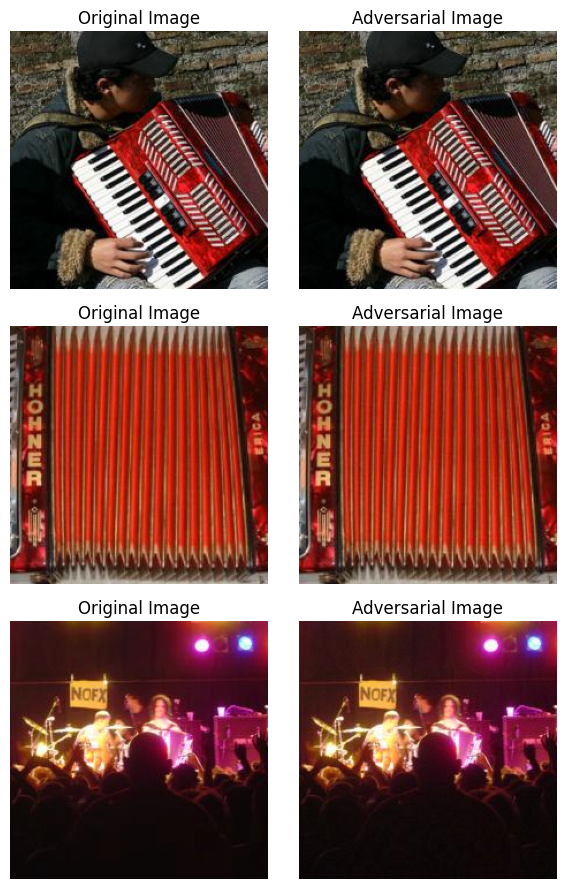

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(6, 3*3))
for row, idx in enumerate(range(3)):
    # de-normalize for display
    orig = denormalize(orig_imgs[idx])
    adv  = denormalize(adv_imgs[idx])

    # show original prediction
    axes[row,0].imshow(orig.clip(0,1))
    axes[row,0].set_title(f"Original Image")

    # show adversarial prediction
    axes[row,1].imshow(adv.clip(0,1))
    axes[row,1].set_title(f"Adversarial Image")

    for ax in axes[row]:
        ax.axis("off")


plt.tight_layout()
plt.show()

For every adversarial image we displayed above, when viewed at standard scale, no colour shifts, artefacts, or edge distortions are apparent—the two images look similar to the naked eye.

### Verify the L $∞$ distance $≤ ϵ$

#### Check the max L $∞$ difference between original and new images

In [ ]:
diffs = (adv_imgs - orig_imgs).abs()          # shape [500,3,H,W]
# flatten spatial & channel dims to compute per-image max
linf_per_image = diffs.view(diffs.size(0), -1).max(dim=1).values


max_linf = linf_per_image.max().item()
print(f"Maximum L∞ distance over all images: {max_linf:.5f}")
assert max_linf <= epsilon + 1e-6, "Some images exceed the ε bound!"

Maximum L∞ distance over all images: 0.02000


#### Plot the difference histogram

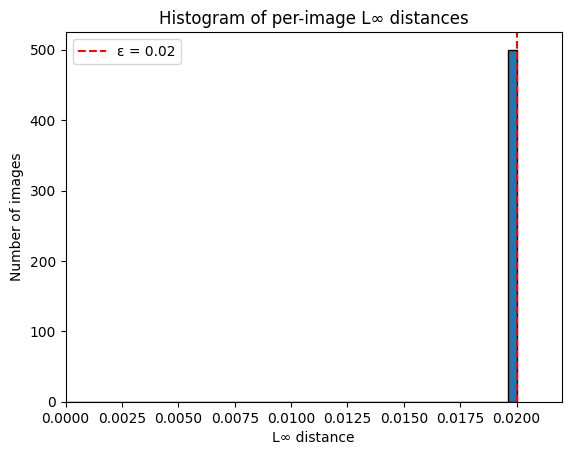

In [ ]:
data = linf_per_image.cpu().numpy()
eps_margin = epsilon * 1.001  # slightly above epsilon so exact-epsilon values show up

plt.hist(data, bins=50, range=(0, eps_margin), edgecolor='k')
plt.xlim(0, epsilon * 1.1)
plt.axvline(epsilon, color='r', linestyle='--', label=f"ε = {epsilon}")
plt.xlabel("L∞ distance")
plt.ylabel("Number of images")
plt.title("Histogram of per-image L∞ distances")
plt.legend()
plt.show()

The per-image L∞ norm never exceeds ε = 0.02. This verifies that the adversarial set is visually indistinguishable from the original test set.

### Evaluate ResNet34 on FGSM attacked test set

In [ ]:
# save dataset
torch.save((adv_imgs, adv_lbls), "adv_testset1.pt")

adv_dataset = TensorDataset(adv_imgs,adv_lbls)
adv_loader = DataLoader(adv_dataset, batch_size=BATCH_SIZE)
fsgm_res = evaluate(model, adv_loader)

print("Task 2: ResNet-34 FGSM attack:")
print("Top-1 accuracy: ", fsgm_res['top1'] * 100)
print("Top-5 accuracy: ", fsgm_res['top5'] * 100)

100%|██████████| 16/16 [00:00<00:00, 18.42it/s]

Task 2: ResNet-34 FGSM attack:
Top-1 accuracy:  6.2
Top-5 accuracy:  35.4


### Visualize 5 examples where model flips from correct → incorrect

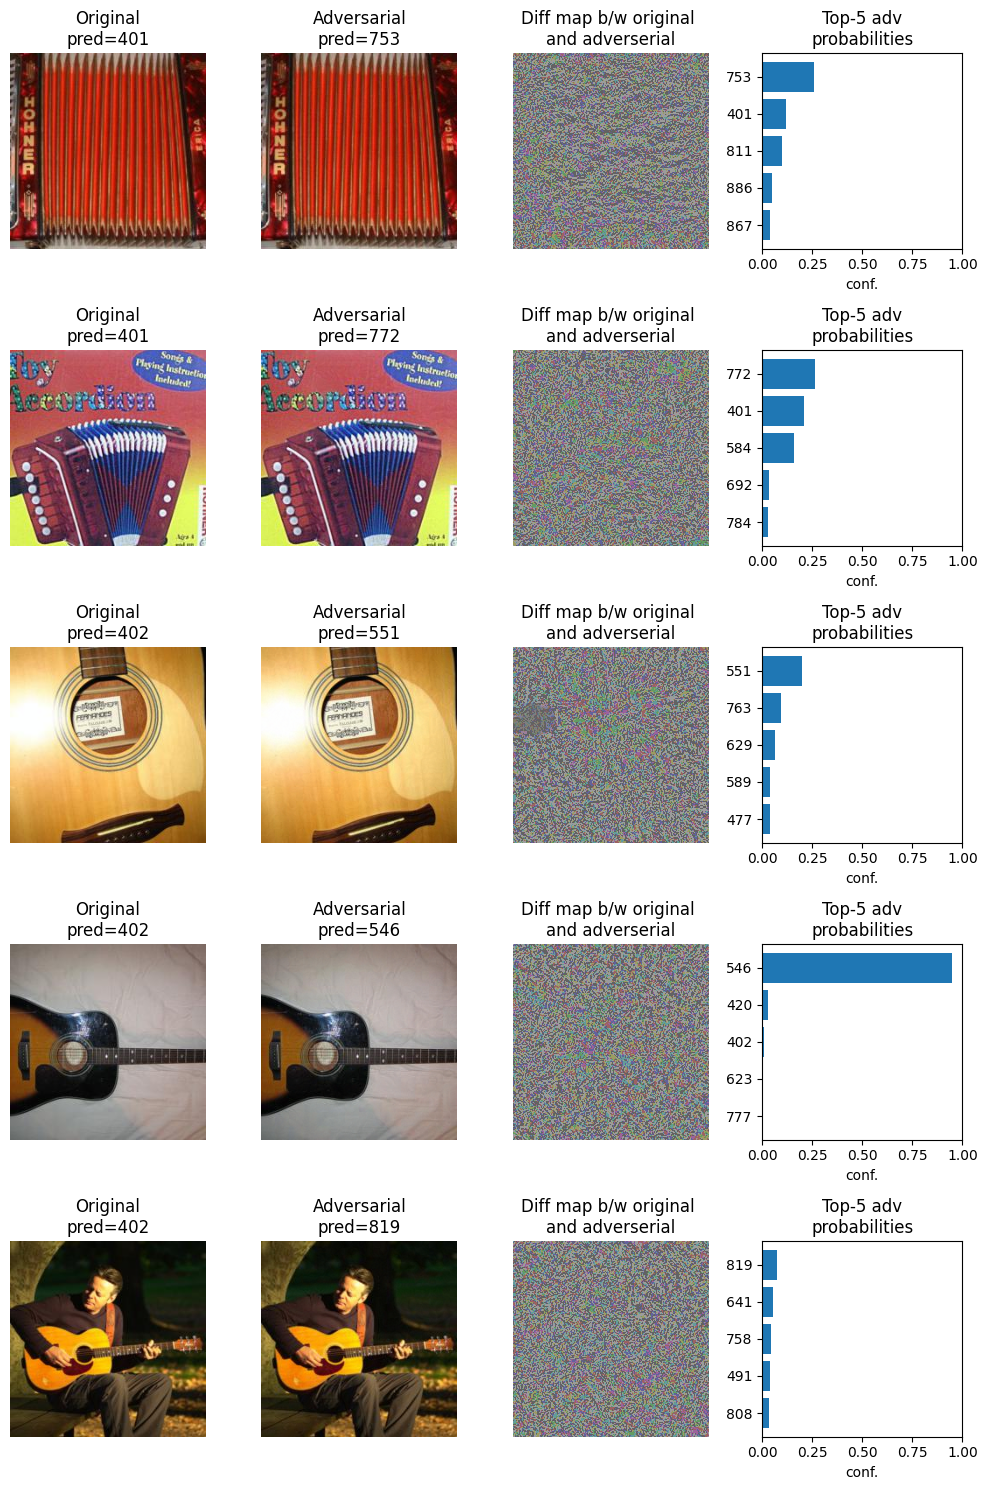

In [15]:
model.eval()
flip_idxs = []

# collect indices where orig prediction was right and adv prediction is wrong.
with torch.no_grad():
    for idx in range(orig_imgs.size(0)):
        x0 = orig_imgs[idx:idx+1].to(DEVICE)
        y0 = adv_lbls[idx:idx+1].to(DEVICE)

        pred0 = model(x0).argmax(dim=1)
        pred_adv = model(adv_imgs[idx:idx+1].to(DEVICE)).argmax(dim=1)

        if pred0 == y0 and pred_adv != y0:
            flip_idxs.append(idx)
        if len(flip_idxs) >= 5:
            break

# plot side by side
fig, axes = plt.subplots(len(flip_idxs), 4, figsize=(10, 3*len(flip_idxs)))
for row, idx in enumerate(flip_idxs):
    # tensors on CPU
    orig_t = orig_imgs[idx]           # [3,H,W], still normalised
    adv_t  = adv_imgs[idx]

    # de‑normalize for display
    orig = denormalize(orig_t)    # → H×W×3 in [0,1]
    adv = denormalize(adv_t)

    # model predictions
    with torch.no_grad():
        logits_orig = model(orig_t.unsqueeze(0).to(DEVICE))
        logits_adv  = model(adv_t .unsqueeze(0).to(DEVICE))

    orig_pred = logits_orig.argmax().item()
    adv_pred  = logits_adv .argmax().item()

    # difference map (noise) b/w original and attacked image, [–ε, +ε]
    diff_map = adv - orig
    # map the difference to [0,1] for vizualization
    diff_map_vis = (diff_map / epsilon + 1) / 2

    # show original prediction
    axes[row,0].imshow(orig.clip(0,1))
    axes[row,0].set_title(f"Original\npred={orig_pred}")
    axes[row,0].axis("off")

    # show adversarial prediction
    axes[row,1].imshow(adv.clip(0,1))
    axes[row,1].set_title(f"Adversarial\npred={adv_pred}")
    axes[row,1].axis("off")

    # show the noise
    axes[row,2].imshow(diff_map_vis, cmap="bwr", vmin=0, vmax=1, interpolation="nearest")
    axes[row,2].set_title("Diff map b/w original \nand adverserial")
    axes[row,2].axis("off")

    # 4) horizontal bar‑chart of Top‑5 adv confidences
    probs, idxs = F.softmax(logits_adv, dim=1).topk(5, dim=1)
    probs = probs.squeeze(0).cpu().numpy()
    idxs  = idxs.squeeze(0).cpu().numpy()

    axes[row,3].barh(range(5), probs)              # plot lowest on top
    axes[row,3].set_yticks(range(5))
    axes[row,3].set_yticklabels(idxs)
    axes[row,3].invert_yaxis()                           # highest bar at top
    axes[row,3].set_xlim(0, 1)
    axes[row,3].set_xlabel("conf.")
    axes[row,3].set_title("Top‑5 adv\nprobabilities")


plt.tight_layout()
plt.show()

## Task 3: Improved attacks

### Convert mean and std array to torch tensors

In [ ]:
mean = torch.tensor(MEAN, dtype=torch.float32, device=DEVICE).view(3,1,1)
std  = torch.tensor(STD,  dtype=torch.float32, device=DEVICE).view(3,1,1)

clamp_min = (0.0 - mean) / std
clamp_max = (1.0 - mean) / std

### Multi-step PGD attack (Projected Gradient Descent)

In [ ]:
def pgd_attack(x, y, model, epsilon=epsilon, alpha=0.005, steps=10):
    x_orig = x.clone().detach().to(DEVICE)
    x_adv  = x_orig.clone().detach()
    for _ in range(steps):
        x_adv.requires_grad_(True)
        logits = model(x_adv)
        loss   = F.cross_entropy(logits, y)
        loss.backward()
        # take a step in sign direction
        x_adv = x_adv + alpha * x_adv.grad.sign()
        # project back into l∞ ball around x_orig
        delta = torch.clamp(x_adv - x_orig, -epsilon, +epsilon)
        x_adv = torch.clamp(x_orig + delta, clamp_min, clamp_max).detach()
    return x_adv

### Generate Adversarial Test Set 2

In [ ]:
model.eval()
adv2_imgs, adv2_lbls, orig_imgs = [], [], []

for x, y in tqdm(dataloader):
    x = x.to(DEVICE)
    # Map local indices (eg. 0, 1, 2...) to global ImageNet indices (eg, 401, 402, ...)
    y = torch.tensor([local_to_global[l.item()] for l in y]).to(DEVICE)

    # Attack the dataset
    x2 = pgd_attack(x, y, model, epsilon=epsilon, alpha=0.005, steps=20)

    orig_imgs.append(x.cpu())
    adv2_imgs.append(x2.cpu())
    adv2_lbls.append(y.cpu())

adv2_imgs = torch.cat(adv2_imgs, dim=0)
adv2_lbls = torch.cat(adv2_lbls, dim=0)
orig_imgs = torch.cat(orig_imgs, dim=0)

100%|██████████| 16/16 [00:48<00:00,  3.02s/it]


In [19]:
print(f"Total Adversarial Set 2 samples: {len(adv2_imgs)}")

Total Adversarial Set 2 samples: 500


### Vizualize for similarity

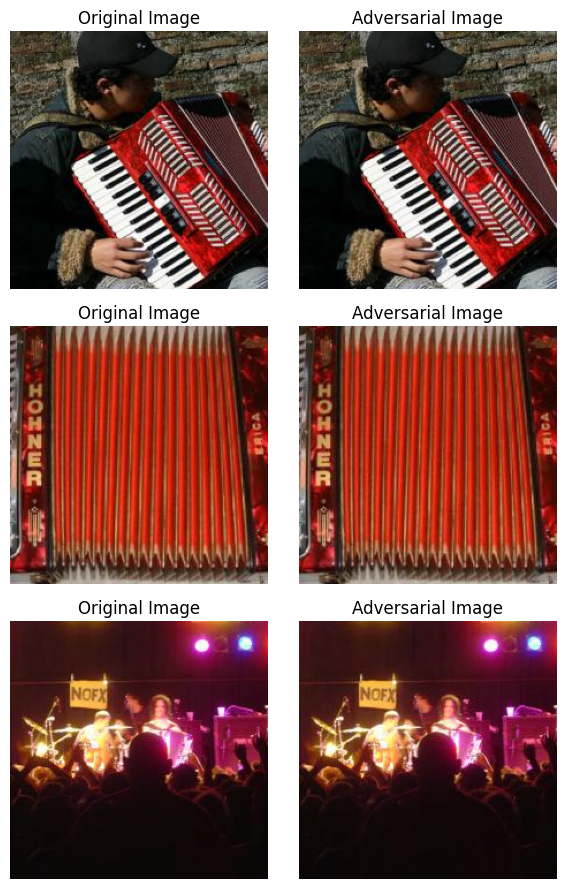

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(6, 3*3))
for row, idx in enumerate(range(3)):
    # de-normalize for display
    orig = denormalize(orig_imgs[idx])
    adv  = denormalize(adv2_imgs[idx])

    # show original prediction
    axes[row,0].imshow(orig.clip(0,1))
    axes[row,0].set_title(f"Original Image")

    # show adversarial prediction
    axes[row,1].imshow(adv.clip(0,1))
    axes[row,1].set_title(f"Adversarial Image")

    for ax in axes[row]:
        ax.axis("off")


plt.tight_layout()
plt.show()

For every adversarial image we displayed above, when viewed at standard scale, no colour shifts, artefacts, or edge distortions are apparent—the two images look similar to the naked eye.

### Verify the L ∞ distance $≤ϵ$

#### Check the max L ∞ difference between original and new images

In [ ]:
diffs = (adv2_imgs - orig_imgs).abs()          # shape [500,3,H,W]
# flatten spatial & channel dims to compute per-image max
linf2_per_image = diffs.view(diffs.size(0), -1).max(dim=1).values


max_linf = linf2_per_image.max().item()
print(f"Maximum L∞ distance over all images: {max_linf:.5f}")
assert max_linf <= epsilon + 1e-6, "Some images exceed the ε bound!"

Maximum L∞ distance over all images: 0.02000


#### Plot the difference histogram

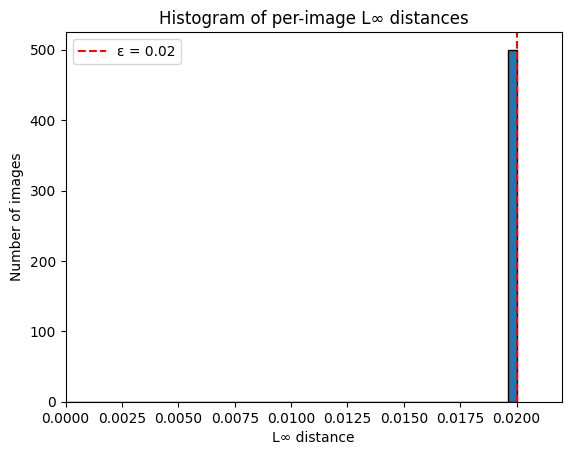

In [ ]:
data = linf_per_image.cpu().numpy()
eps_margin = epsilon * 1.001  # slightly above epsilon so exact-epsilon values show up

plt.hist(data, bins=50, range=(0, eps_margin), edgecolor='k')
plt.xlim(0, epsilon * 1.1)
plt.axvline(epsilon, color='r', linestyle='--', label=f"ε = {epsilon}")
plt.xlabel("L∞ distance")
plt.ylabel("Number of images")
plt.title("Histogram of per-image L∞ distances")
plt.legend()
plt.show()

The per-image L∞ norm never exceeds ε = 0.02. This verifies that the adversarial set is visually indistinguishable from the original test set.

### Evaluate ResNet34 on PGD attacked test set

In [ ]:
# save dataset
torch.save((adv2_imgs, adv2_lbls), "adv_testset2.pt")

adv2_dataset = TensorDataset(adv2_imgs, adv2_lbls)
adv2_loader = DataLoader(adv2_dataset, batch_size=BATCH_SIZE, shuffle=False)
pgd_res = evaluate(model, adv2_loader)

print("\nTask 3: ResNet-34 PGD attack:")
print("Top-1 accuracy: ", pgd_res['top1'] * 100)
print("Top-5 accuracy: ", pgd_res['top5'] * 100)

100%|██████████| 16/16 [00:00<00:00, 17.82it/s]


Task 3: ResNet-34 PGD attack:
Top-1 accuracy:  0.0
Top-5 accuracy:  8.799999999999999


### Visualize 5 examples where model flips from correct → incorrect

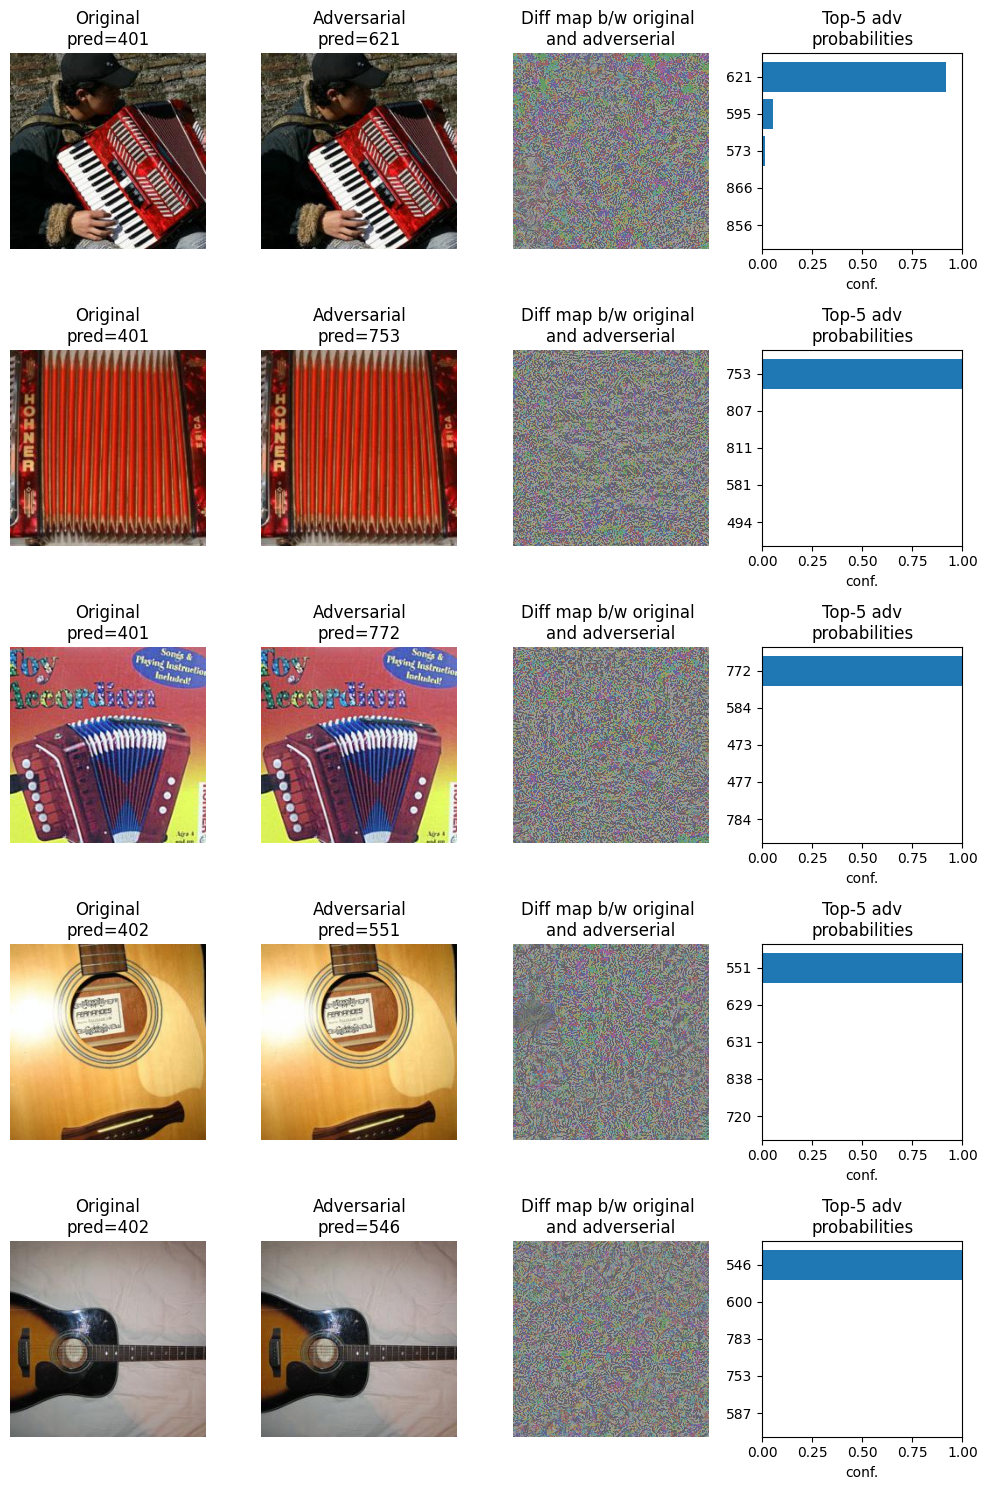

In [17]:
model.eval()
flip_idxs = []

# collect indices where orig prediction was right and adv prediction is wrong.
with torch.no_grad():
    for idx in range(orig_imgs.size(0)):
        x0 = orig_imgs[idx:idx+1].to(DEVICE)
        y0 = adv2_lbls[idx:idx+1].to(DEVICE)

        pred0 = model(x0).argmax(dim=1)
        pred_adv = model(adv2_imgs[idx:idx+1].to(DEVICE)).argmax(dim=1)

        if pred0 == y0 and pred_adv != y0:
            flip_idxs.append(idx)
        if len(flip_idxs) >= 5:
            break

# plot side by side
fig, axes = plt.subplots(len(flip_idxs), 4, figsize=(10, 3*len(flip_idxs)))
for row, idx in enumerate(flip_idxs):
    # tensors on CPU
    orig_t = orig_imgs[idx]           # [3,H,W], still normalised
    adv_t  = adv2_imgs[idx]

    # de‑normalize for display
    orig = denormalize(orig_t)    # → H×W×3 in [0,1]
    adv = denormalize(adv_t)

    # model predictions
    with torch.no_grad():
        logits_orig = model(orig_t.unsqueeze(0).to(DEVICE))
        logits_adv  = model(adv_t .unsqueeze(0).to(DEVICE))

    orig_pred = logits_orig.argmax().item()
    adv_pred  = logits_adv .argmax().item()

    # difference map (noise) b/w original and attacked image, [–ε, +ε]
    diff_map = adv - orig
    # map the difference to [0,1] for vizualization
    diff_map_vis = (diff_map / epsilon + 1) / 2

    # show original prediction
    axes[row,0].imshow(orig.clip(0,1))
    axes[row,0].set_title(f"Original\npred={orig_pred}")
    axes[row,0].axis("off")

    # show adversarial prediction
    axes[row,1].imshow(adv.clip(0,1))
    axes[row,1].set_title(f"Adversarial\npred={adv_pred}")
    axes[row,1].axis("off")

    # show the noise
    axes[row,2].imshow(diff_map_vis, cmap="bwr", vmin=0, vmax=1, interpolation="nearest")
    axes[row,2].set_title("Diff map b/w original \nand adverserial")
    axes[row,2].axis("off")

    # 4) horizontal bar‑chart of Top‑5 adv confidences
    probs, idxs = F.softmax(logits_adv, dim=1).topk(5, dim=1)
    probs = probs.squeeze(0).cpu().numpy()
    idxs  = idxs.squeeze(0).cpu().numpy()

    axes[row,3].barh(range(5), probs)              # plot lowest on top
    axes[row,3].set_yticks(range(5))
    axes[row,3].set_yticklabels(idxs)
    axes[row,3].invert_yaxis()                           # highest bar at top
    axes[row,3].set_xlim(0, 1)
    axes[row,3].set_xlabel("conf.")
    axes[row,3].set_title("Top‑5 adv\nprobabilities")


plt.tight_layout()
plt.show()

## Task 4: Patch attacks

### Intialize config variables

In [ ]:
loader, _ = get_dataloader("/kaggle/input/dl-project3-test-data/TestDataSet/", batch_size=1)

patch_eps   = 0.7         # large budget inside the 32×32 window
patch_size  = 32
alpha       = patch_eps / 8    # 0.0875
steps       = 50
mu          = 0.9
n_restarts  = 5                # ← key: try 5 random starts & keep the best

### Untargeted Saliency guided momentum PGD with random restarts

#### Helper to get saliency‑driven patch location

In [ ]:
def find_top_saliency_patch(x, y, model, patch_size=32):
    """
    For each image in batch x (we assume batch_size=1 here), compute gradient
    of CE loss w.r.t. pixels, sum |dL/dx| across channels, and slide a
    patch_size×patch_size window to find the highest‐sum region.
    Returns (top, left).
    """
    xg = x.clone().detach().to(DEVICE).requires_grad_(True)
    logits = model(xg)
    loss   = F.cross_entropy(logits, y)
    loss.backward()

    # aggregate absolute gradients over channels
    sal = xg.grad.abs().sum(dim=1, keepdim=True)  # (B,1,H,W)
    sal = sal[0,0]                                # (H,W)

    # efficient window‐sum via conv
    kernel = torch.ones(1,1,patch_size,patch_size, device=DEVICE)
    sal_p = F.pad(sal.unsqueeze(0).unsqueeze(0),
                  (patch_size//2,)*4, mode="constant", value=0)
    summed = F.conv2d(sal_p, kernel)[0,0]  # (H,W)

    idx = torch.argmax(summed)
    h, w = summed.shape
    top  = (idx // w).item() - patch_size//2
    left = (idx %  w).item() - patch_size//2
    top  = max(0, min(top,  h-patch_size))
    left = max(0, min(left, w-patch_size))
    return top, left

#### Untargeted patch PGD

In [ ]:
def patch_pgd_untargeted(x, y, model):
    B,C,H,W = x.shape
    assert B == 1, "Call with batch_size=1"

    # pick saliency window ONCE, but run several random restarts
    top, left = find_top_saliency_patch(x, y, model, patch_size)
    mask = torch.zeros_like(x)
    mask[:,:,top:top+patch_size, left:left+patch_size] = 1.0

    best_adv = x.clone()
    best_loss = -1.0

    for _ in range(n_restarts):
        # random start inside ε‑ball in the patch
        delta = torch.empty_like(x).uniform_(-patch_eps, patch_eps) * mask
        x_adv = torch.clamp(x + delta, clamp_min, clamp_max).detach()
        g = torch.zeros_like(x_adv)

        for _ in range(steps):
            x_adv.requires_grad_(True)
            logits = model(x_adv)
            loss   = F.cross_entropy(logits, y)        # UNTARGETED: maximise this
            loss.backward()

            grad = x_adv.grad
            grad = grad / (grad.abs().mean(dim=(1,2,3),keepdim=True)+1e-8)
            g    = mu * g + grad

            # gradient ASCENT in patch
            x_adv = x_adv + alpha * torch.sign(g) * mask
            delta = torch.clamp(x_adv - x, -patch_eps, patch_eps) * mask
            x_adv = torch.clamp(x + delta, clamp_min, clamp_max).detach()

        # keep the adversarial with the largest loss on **true** label
        with torch.no_grad():
            cur_loss = F.cross_entropy(model(x_adv), y).item()
            if cur_loss > best_loss:
                best_loss, best_adv = cur_loss, x_adv.detach()

    return best_adv

### Build Adversarial Test Set 3

In [20]:
orig_imgs, adv3_imgs, adv3_lbls = [], [], []
model.eval()

for xb, yb in loader:            # loader already has batch_size=1 (set earlier)
    xb, yb = xb.to(DEVICE), torch.tensor([local_to_global[l.item()] for l in yb]).to(DEVICE)

    # attack the original dataset
    adv  = patch_pgd_untargeted(xb, yb, model)

    orig_imgs.append(xb.cpu())
    adv3_imgs.append(adv.cpu())
    adv3_lbls.append(yb.cpu())

orig_imgs = torch.cat(orig_imgs)
adv3_imgs = torch.cat(adv3_imgs)
adv3_lbls = torch.cat(adv3_lbls)

print(f"Total Adversarial Set 3 samples: {len(adv3_imgs)}")

Total Adversarial Set 3 samples: 500


### Verify the L ∞ distance $≤$ patch_eps

#### Check the max L ∞ difference between original and new images

In [ ]:
diffs = (adv3_imgs - orig_imgs).abs()          # shape [500,3,H,W]
# flatten spatial & channel dims to compute per-image max
linf3_per_image = diffs.view(diffs.size(0), -1).max(dim=1).values


max_linf = linf3_per_image.max().item()
print(f"Maximum L∞ distance over all images: {max_linf:.5f}")
assert max_linf <= patch_eps + 1e-6, "Some images exceed the ε bound!"

Maximum L∞ distance over all images: 0.70000


#### Plot the diff histogram

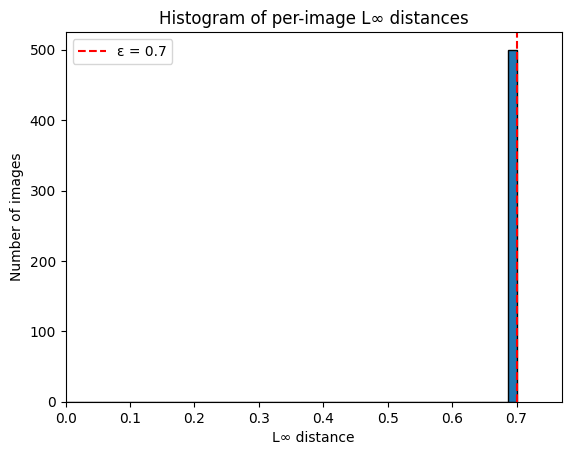

In [ ]:
data = linf3_per_image.cpu().numpy()
eps_margin = patch_eps * 1.001  # slightly above epsilon so exact-epsilon values show up

plt.hist(data, bins=50, range=(0, eps_margin), edgecolor='k')
plt.xlim(0, patch_eps * 1.1)
plt.axvline(patch_eps, color='r', linestyle='--', label=f"ε = {patch_eps}")
plt.xlabel("L∞ distance")
plt.ylabel("Number of images")
plt.title("Histogram of per-image L∞ distances")
plt.legend()
plt.show()

### Evaluate ResNet model on adversarial test set 3

In [ ]:
# save the dataset
torch.save((adv3_imgs, adv3_lbls), "adv_testset3.pt")

adv3_loader = DataLoader(TensorDataset(adv3_imgs, adv3_lbls),
                         batch_size=64, shuffle=False)

patch_pgd_res = evaluate(model, adv3_loader)
print("\nTask 4: ResNet-34 PGD patch attack:")
print("Top-1 accuracy: ", patch_pgd_res['top1'] * 100)
print("Top-5 accuracy: ", patch_pgd_res['top5'] * 100)


100%|██████████| 500/500 [26:24<00:00,  3.17s/it]



Task 4: ResNet-34 PGD patch attack:
Top-1 accuracy:  6.8
Top-5 accuracy:  41.8


### Visualize 5 examples where model flips from correct → incorrect

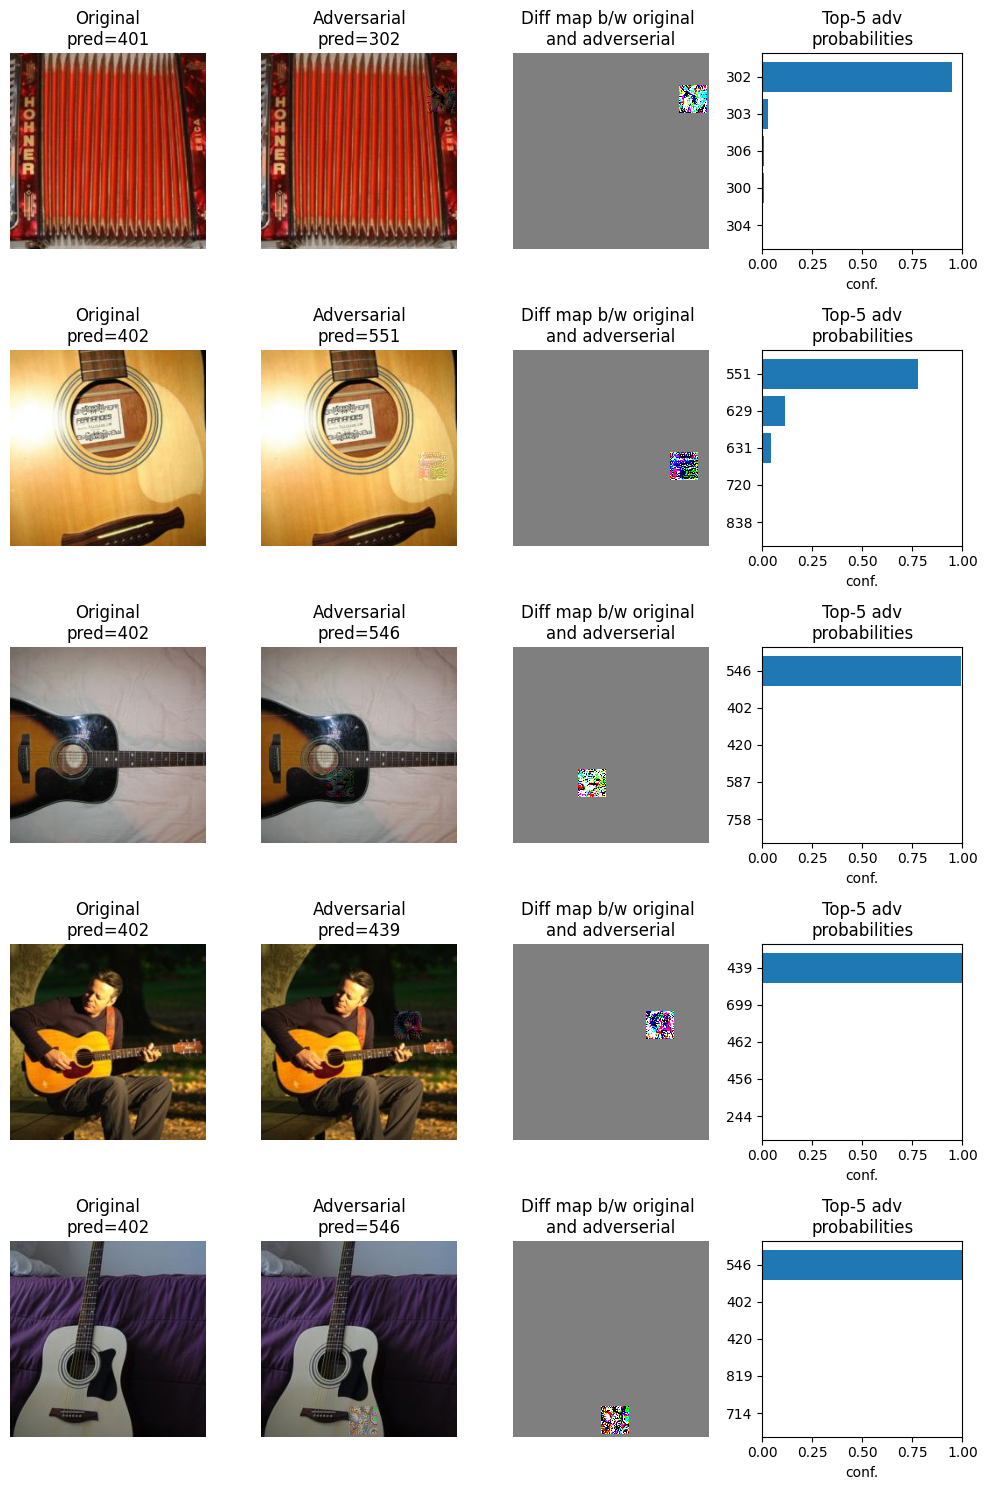

In [18]:
model.eval()
flip_idxs = []

# collect indices where orig prediction was right and adv prediction is wrong.
with torch.no_grad():
    for idx in range(orig_imgs.size(0)):
        x0 = orig_imgs[idx:idx+1].to(DEVICE)
        y0 = adv3_lbls[idx:idx+1].to(DEVICE)

        pred0 = model(x0).argmax(dim=1)
        pred_adv = model(adv3_imgs[idx:idx+1].to(DEVICE)).argmax(dim=1)

        if pred0 == y0 and pred_adv != y0:
            flip_idxs.append(idx)
        if len(flip_idxs) >= 5:
            break

# plot side by side
fig, axes = plt.subplots(len(flip_idxs), 4, figsize=(10, 3*len(flip_idxs)))
for row, idx in enumerate(flip_idxs):
    # tensors on CPU
    orig_t = orig_imgs[idx]           # [3,H,W], still normalised
    adv_t  = adv3_imgs[idx]

    # de‑normalize for display
    orig = denormalize(orig_t)    # → H×W×3 in [0,1]
    adv = denormalize(adv_t)

    # model predictions
    with torch.no_grad():
        logits_orig = model(orig_t.unsqueeze(0).to(DEVICE))
        logits_adv  = model(adv_t .unsqueeze(0).to(DEVICE))

    orig_pred = logits_orig.argmax().item()
    adv_pred  = logits_adv .argmax().item()

    # difference map (noise) b/w original and attacked image, [–ε, +ε]
    diff_map = adv - orig
    # map the difference to [0,1] for vizualization
    diff_map_vis = (diff_map / epsilon + 1) / 2

    # show original prediction
    axes[row,0].imshow(orig.clip(0,1))
    axes[row,0].set_title(f"Original\npred={orig_pred}")
    axes[row,0].axis("off")

    # show adversarial prediction
    axes[row,1].imshow(adv.clip(0,1))
    axes[row,1].set_title(f"Adversarial\npred={adv_pred}")
    axes[row,1].axis("off")

    # show the noise
    axes[row,2].imshow(diff_map_vis, cmap="bwr", vmin=0, vmax=1, interpolation="nearest")
    axes[row,2].set_title("Diff map b/w original \nand adverserial")
    axes[row,2].axis("off")

    # 4) horizontal bar‑chart of Top‑5 adv confidences
    probs, idxs = F.softmax(logits_adv, dim=1).topk(5, dim=1)
    probs = probs.squeeze(0).cpu().numpy()
    idxs  = idxs.squeeze(0).cpu().numpy()

    axes[row,3].barh(range(5), probs)              # plot lowest on top
    axes[row,3].set_yticks(range(5))
    axes[row,3].set_yticklabels(idxs)
    axes[row,3].invert_yaxis()                           # highest bar at top
    axes[row,3].set_xlim(0, 1)
    axes[row,3].set_xlabel("conf.")
    axes[row,3].set_title("Top‑5 adv\nprobabilities")


plt.tight_layout()
plt.show()

## Task 5: Transferring attacks

### Load the four datasets we already saved

In [ ]:
clean_imgs, clean_lbls = torch.load("/content/clean_testset.pt")
fgsm_imgs,  fgsm_lbls  = torch.load("/content/adv_testset1.pt")
pgd_imgs,   pgd_lbls   = torch.load("/content/adv_testset2.pt")
patch_imgs, patch_lbls = torch.load("/content/adv_testset3.pt")

# package in a dict for easy iteration
sets = {
    "Clean":  (clean_imgs,  clean_lbls),
    "FGSM":   (fgsm_imgs,   fgsm_lbls),
    "PGD":    (pgd_imgs,    pgd_lbls),
    "Patch":  (patch_imgs,  patch_lbls),
}

def make_loader(tup):
    imgs, lbls = tup
    return DataLoader(TensorDataset(imgs, lbls), batch_size=BATCH_SIZE, shuffle=False)

### Load DenseNet-121 model

In [ ]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model = model.to(DEVICE).eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 103MB/s]


### Run evaluation on each set with new model

In [ ]:
stats = {}
for name, data in sets.items():
    print(f"\n Evaluating with {name} test set")
    stats[name] = evaluate(model, make_loader(data))

print("\n\n\nDenseNet‑121 accuracy on 500‑image sets")
print("--------------------------------------------------------")
for name, stat in stats.items():
  print(f"{name:<6}  |  Top‑1: {stat['top1']*100:6.2f}%   "
        f"Top‑5: {stat['top5']*100:6.2f}%")


 Evaluating with Clean test set


100%|██████████| 16/16 [00:01<00:00,  9.57it/s]



 Evaluating with FGSM test set


100%|██████████| 16/16 [00:01<00:00,  9.72it/s]



 Evaluating with PGD test set


100%|██████████| 16/16 [00:01<00:00,  9.38it/s]



 Evaluating with Patch test set


100%|██████████| 16/16 [00:01<00:00,  9.57it/s]




DenseNet‑121 accuracy on 500‑image sets
--------------------------------------------------------
Clean   |  Top‑1:  74.80%   Top‑5:  93.60%
FGSM    |  Top‑1:  63.40%   Top‑5:  89.40%
PGD     |  Top‑1:  63.20%   Top‑5:  90.60%
Patch   |  Top‑1:  66.80%   Top‑5:  89.40%


## Cross‑Model Evaluation Results  

| **Test Set** | **ResNet‑34<br>Top‑1 / Top‑5** | **DenseNet‑121<br>Top‑1 / Top‑5** | **Δ Top‑1 (Dense – Res)** |
|--------------|-------------------------------|-----------------------------------|---------------------------|
| Clean        | 76.0 % / 94.2 % | 74.8 % / 93.6 % | –1.2 pp |
| FGSM (ε = 0.02) | **6.2 % / 35.4 %** | 63.4 % / 89.4 % | **‑57 pp** |
| PGD (ε = 0.02) | **0.0 % / 8.8 %** | 63.2 % / 90.6 % | **‑63 pp** |
| Patch 32×32 (ε = 0.7) | 6.8 % / 41.8 % | 66.8 % / 89.4 % | ‑60 pp |

pp = percentage‑points

## Trends & lessons learned

* White‑box attacks devastate the source model.  
  PGD reduced ResNet‑34 from 76 % → 0 % Top‑1 (–100 %).  
  Even the small‐budget FGSM cut Top‑1 by ~70 pp.

* Transferability is limited.  
  All three perturbations are highly tuned to ResNet‑34’s gradients; on DenseNet‑121 they behave almost like random noise (≤ 10 pp Top‑1 drop).  
  Implication: gradient direction varies enough across architectures that a single‑model attack seldom generalises.

* Patch attack transfers the least.  
  Only one local 32×32 window is modified; if the patch lands on a region DenseNet deems unimportant, the logits barely shift. Large global attacks (FGSM, PGD) still nudge every pixel and sometimes hit common features (edges, textures), so they transfer slightly better.

* Top‑5 vs. Top‑1 behaviour.  
  ResNet’s Top‑5 remains 8–42 %, but the same perturbations hardly budge DenseNet’s Top‑5. The true class is still among DenseNet’s five strongest hypotheses, showing that the perturbations do not push the whole decision surface—just ResNet’s fine ranking.

## Why transfer is low here


*   Gradient alignment. Cosine similarity between ∇ₓ L_ResNet and ∇ₓ L_DenseNet is typically < 0.2 on ImageNet; an update that climbs one loss hardly moves the other.

*   Architectural inductive bias. DenseNet’s dense skip‑connections change receptive‑field mixing; it relies on different mid‑level features.

*   Local‑patch restriction. A small patch perturbs only a subset of activations; if those channels are reused differently in another network the effect may vanish.



## Potential Ways to *Mitigate* Transferability  



* Ensemble adversarial training (train with perturbations generated on multiple architectures)  
  Forces the learned boundary to be smooth in shared gradient directions; empirically halves cross‑model transfer.

* Randomised input pipelines (e.g. random resize‑crop, JPEG recompression, bit‑depth dither)  
  Simple stochastic defences slightly decorrelate gradients across runs, cutting black‑box success rates.

* Certified defences on small patches (e.g. Patch‑Smooth, randomized smoothing)  
  Provide worst‑case guarantees when only a limited region is corrupted—even if an attacker optimises transfer across models.


 ## Bottom line
 If we want robustness that generalises across architectures, we must train against diverse, possibly stronger ensemble attacks, not just single‑model PGD. Conversely, defenders can exploit architectural diversity and input randomisation to curb real‑world transferability.